In [1]:
from astropy.io import fits
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import resample

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data = fits.open('data_lt_sprat/v_a_20190516_57_1_0_1.fits')[0].data

<ipython-input-3-a0c827e8d172>:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(data.data), aspect='auto', origin='lower')


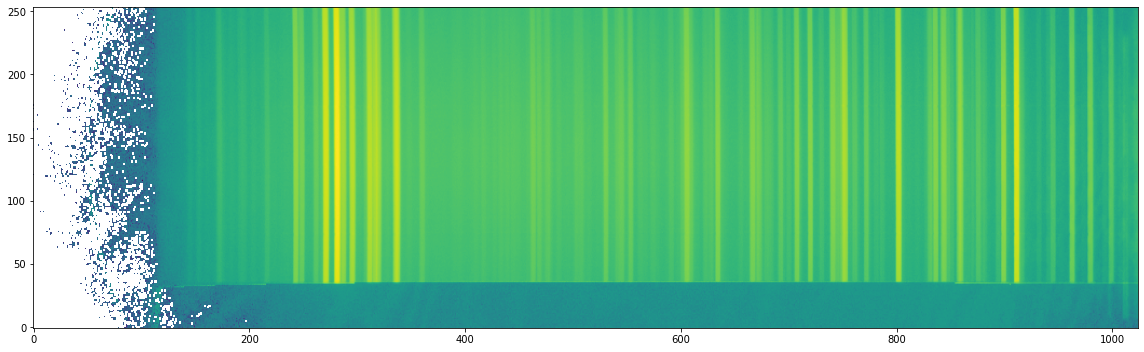

In [3]:
plt.figure(1, figsize=(16,5))
plt.imshow(np.log(data.data), aspect='auto', origin='lower')
plt.tight_layout()

In [4]:
spectrum = np.median(data[110:120], axis=0)

peaks, _ = find_peaks(spectrum, height=500, distance=5, threshold=None)
peaks_refined = refine_peaks(spectrum, peaks, window_width=5)

atlas = [
    4193.5, 4385.77, 4500.98, 4524.68, 4582.75, 4624.28, 4671.23, 4697.02,
    4734.15, 4807.02, 4921.48, 5028.28, 5618.88, 5823.89, 5893.29, 5934.17,
    6182.42, 6318.06, 6472.841, 6595.56, 6668.92, 6728.01, 6827.32, 6976.18,
    7119.60, 7257.9, 7393.8, 7584.68, 7642.02, 7740.31, 7802.65, 7887.40,
    7967.34, 8057.258
]
element = ['Xe'] * len(atlas)

In [5]:
c = Calibrator(peaks_refined, spectrum)
               
c.set_calibrator_properties(num_pix=len(spectrum),
                            plotting_library='matplotlib',
                            log_level='info') 
c.set_hough_properties(num_slopes=5000,
                       xbins=100,
                       ybins=100,
                       min_wavelength=3500.,
                       max_wavelength=8000.,
                       range_tolerance=500.,
                       linearity_tolerance=50)
c.load_user_atlas(elements=element,
                  wavelengths=atlas,
                  constrain_poly=True)

c.set_ransac_properties(sample_size=5,
                        top_n_candidate=5,
                        linear=True,
                        filter_close=True,
                        ransac_thresh=5,
                        candidate_weighted=True,
                        hough_weight=1.0)
c.do_hough_transform()

INFO:rascal.calibrator:num_pix is set to 1024.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.


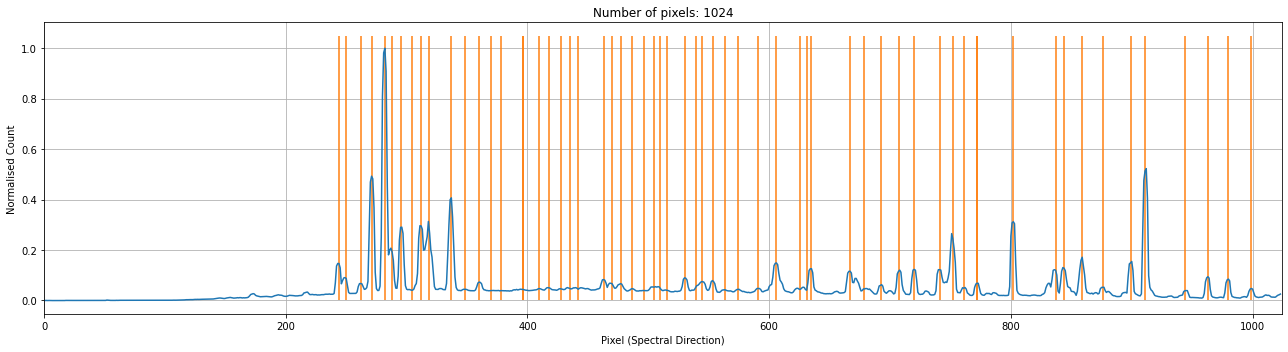

In [6]:
c.plot_arc()

INFO:rascal.calibrator:Peak at: 4499.364599593868 A
INFO:rascal.calibrator:- matched to 4500.98 A
INFO:rascal.calibrator:Peak at: 4526.612530847922 A
INFO:rascal.calibrator:- matched to 4524.68 A
INFO:rascal.calibrator:Peak at: 4582.438582902465 A
INFO:rascal.calibrator:- matched to 4582.75 A
INFO:rascal.calibrator:Peak at: 4622.388370938885 A
INFO:rascal.calibrator:- matched to 4624.28 A
INFO:rascal.calibrator:Peak at: 4670.376861180728 A
INFO:rascal.calibrator:- matched to 4671.23 A
INFO:rascal.calibrator:Peak at: 4699.209968774314 A
INFO:rascal.calibrator:- matched to 4697.02 A
INFO:rascal.calibrator:Peak at: 4733.794495986758 A
INFO:rascal.calibrator:- matched to 4734.15 A
INFO:rascal.calibrator:Peak at: 4771.918269446537 A
INFO:rascal.calibrator:Peak at: 4808.813158043653 A
INFO:rascal.calibrator:- matched to 4807.02 A
INFO:rascal.calibrator:Peak at: 4837.622383210545 A
INFO:rascal.calibrator:Peak at: 4921.095371816489 A
INFO:rascal.calibrator:- matched to 4921.48 A
INFO:rascal.ca

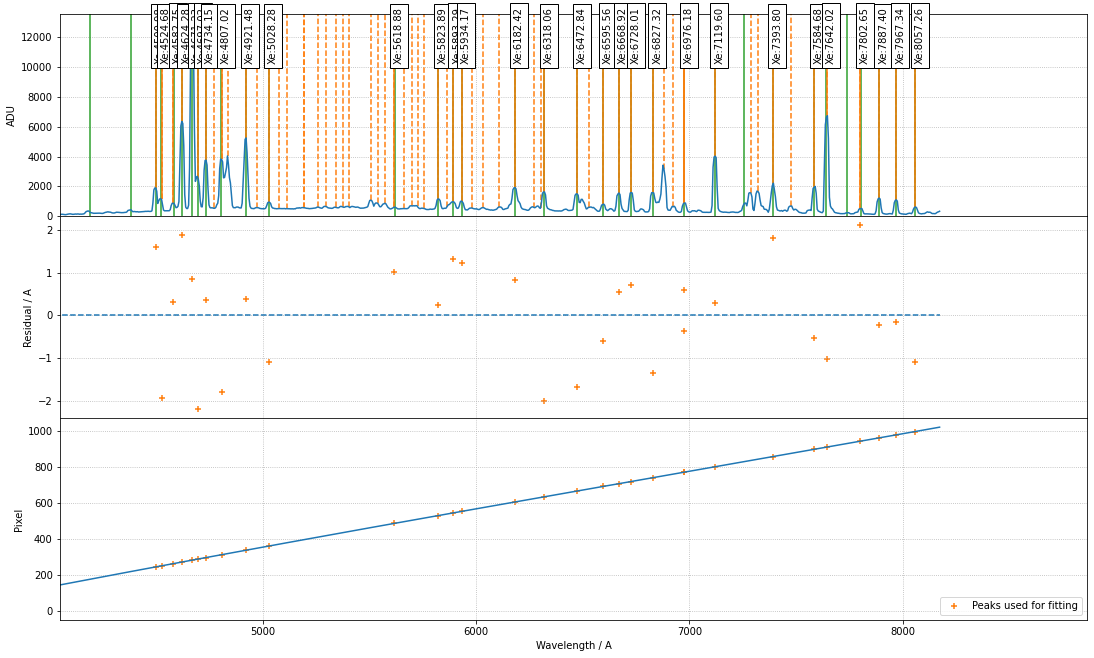

Stdev error: 0.6267986911634755 A
Peaks utilisation rate: 355.88235294117646%


In [7]:
polyfit_coeff, rms, residual, peak_utilisation = c.fit(max_tries=500)

c.plot_fit(polyfit_coeff,
           plot_atlas=True,
           log_spectrum=False,
           tolerance=10.,
           renderer='notebook')

rms = np.sqrt(np.sum(residual**2 / len(residual)))

print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

# Now, we refine this set of polynomial coefficients and apply to a different night of arc

In [8]:
data2 = fits.open('data_lt_sprat/v_a_20200409_39_1_0_1.fits')[0].data
spectrum2 = np.median(data2[105:110], axis=0)

peaks2, _ = find_peaks(spectrum2, height=600, distance=5, threshold=None)
peaks_refined2 = refine_peaks(spectrum2, peaks2, window_width=5)

## Fit using the polynomial fit coefficients as the first best guess

INFO:rascal.calibrator:num_pix is set to 1024.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.


INFO:rascal.calibrator:Peak at: 4499.924388891592 A
INFO:rascal.calibrator:- matched to 4500.98 A
INFO:rascal.calibrator:Peak at: 4526.596835646279 A
INFO:rascal.calibrator:- matched to 4524.68 A
INFO:rascal.calibrator:Peak at: 4622.7502048373235 A
INFO:rascal.calibrator:- matched to 4624.28 A
INFO:rascal.calibrator:Peak at: 4670.6052235317065 A
INFO:rascal.calibrator:- matched to 4671.23 A
INFO:rascal.calibrator:Peak at: 4697.79337130848 A
INFO:rascal.calibrator:- matched to 4697.02 A
INFO:rascal.calibrator:Peak at: 4733.72462460166 A
INFO:rascal.calibrator:- matched to 4734.15 A
INFO:rascal.calibrator:Peak at: 4808.89372677376 A
INFO:rascal.calibrator:- matched to 4807.02 A
INFO:rascal.calibrator:Peak at: 4837.406683481382 A
INFO:rascal.calibrator:Peak at: 4920.665033278964 A
INFO:rascal.calibrator:- matched to 4921.48 A
INFO:rascal.calibrator:Peak at: 5029.195453936643 A
INFO:rascal.calibrator:- matched to 5028.28 A
INFO:rascal.calibrator:Peak at: 5373.1955657457365 A
INFO:rascal.ca

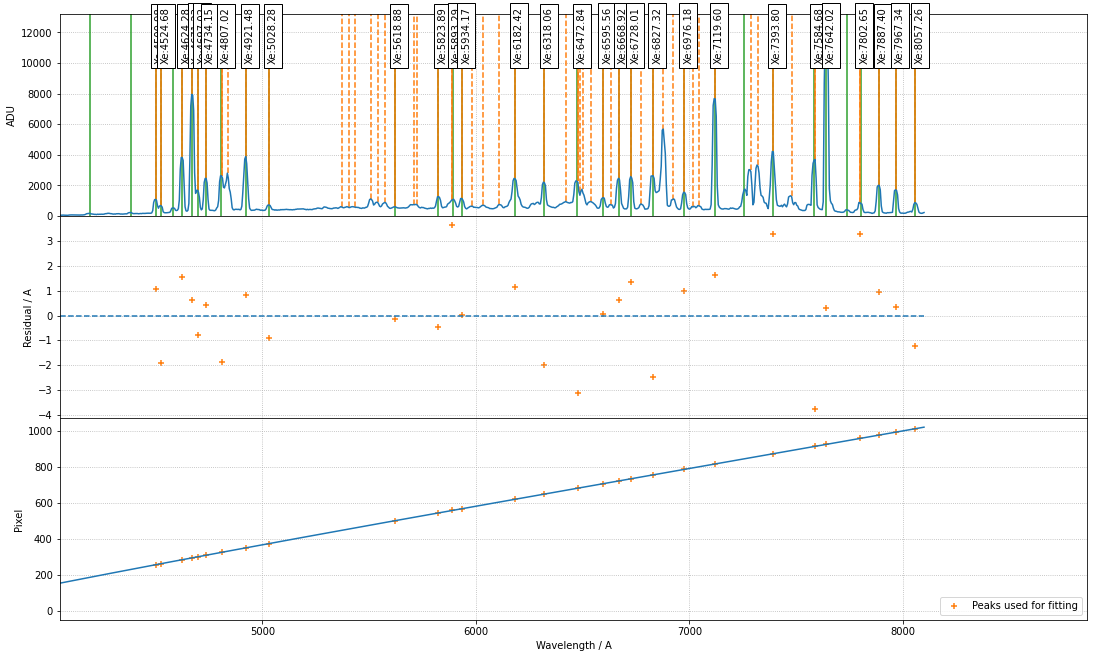

Stdev error: 1.0603999401953481 A
Peaks utilisation rate: 273.5294117647059%


In [9]:
c2 = Calibrator(peaks_refined2, spectrum2)
               
c2.set_calibrator_properties(num_pix=len(spectrum2),
                            plotting_library='matplotlib',
                            log_level='info') 
c2.set_hough_properties(num_slopes=5000,
                       xbins=100,
                       ybins=100,
                       min_wavelength=3500.,
                       max_wavelength=8000.,
                       range_tolerance=500.,
                       linearity_tolerance=50)
c2.load_user_atlas(elements=element,
                  wavelengths=atlas,
                  constrain_poly=True)

c2.set_ransac_properties(sample_size=5,
                        top_n_candidate=5,
                        linear=True,
                        filter_close=True,
                        ransac_thresh=5,
                        candidate_weighted=True,
                        hough_weight=1.0)
c2.do_hough_transform()

polyfit_coeff2, rms2, residual2, peak_utilisation2 = c2.fit(max_tries=500, polyfit_coeff=polyfit_coeff)

c2.plot_fit(polyfit_coeff2,
            plot_atlas=True,
            log_spectrum=False,
            tolerance=10.,
            renderer='notebook')

rms2 = np.sqrt(np.sum(residual2**2 / len(residual2)))

print("Stdev error: {} A".format(np.abs(residual2).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation2*100))

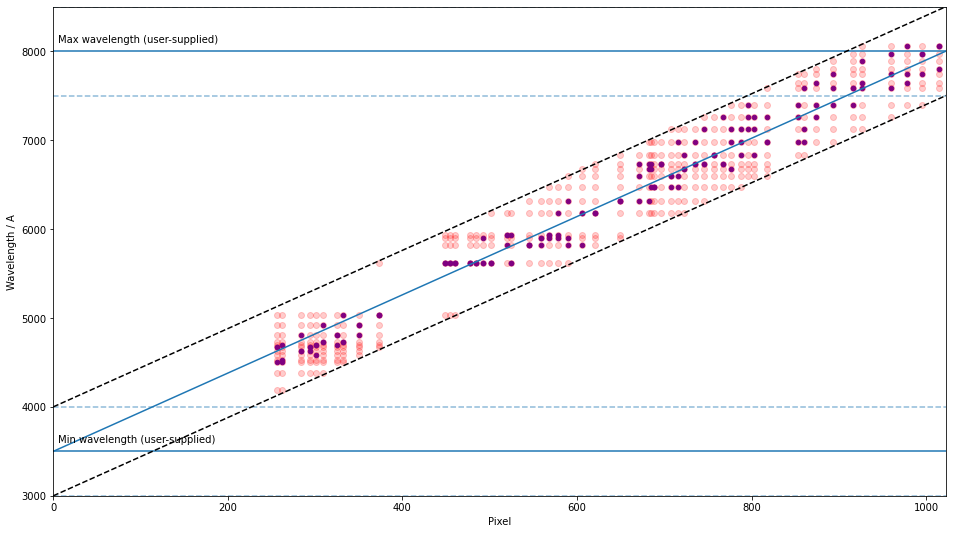

In [10]:
c2.plot_search_space()